# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Luca Fetz & Mohammed-Ismail Ben Salah
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os
import numpy as np
import scipy as scp

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

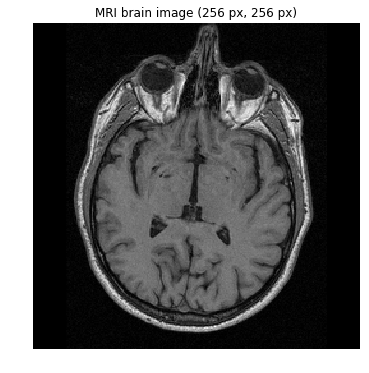

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
In this implementation of region growing i chose a local homogeneity criterion (difference between frontier pixel and its neighbor under a threshold). The brain is quite well detected, but the region has many holes. Area is simply computed as sum of accepted pixels. To make it smoother we could apply a closing morphological operator or we could change the homogeneity criterion to consider the mean and std of our accepted pixels.

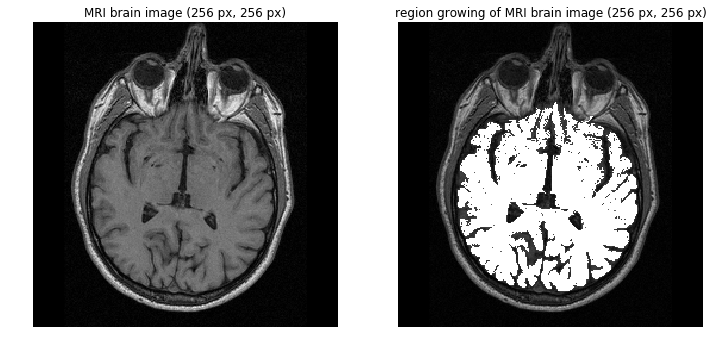

The brain is 14350 pixels wide.


In [4]:
#region growing method. Start somewhere and recursively see if neighboring pixels satisfy homogeneity criterion
#homogeneity threshold: intensity between twe neighbors lower than threshold
#stard point: 128,140
#threshold = 10 #used for the local homogeneity
threshold = 16 #used for the mean homogeneity
area, old_area = 1, 0
x,y = 128, 140
region_g = brain_im.copy()
#table with 0 not visited, 1 visited and part of the region, 2 visited and part of the frontier, 3 visited and not part of the region
visit_table = np.zeros((im_h,im_w),dtype = int)
visit_table[x][y] = 2

mean = region_g[x][y]

while old_area < area:
    old_area = area
    #look in image where we need to visit neighbors
    for k in range(1, im_h-1):#all image except last lines and columns which won't have unvisited neighbors
        for l in range(1,im_w-1):
            if visit_table[k][l] == 2: #if it is part of the frontier we look at its neighbors
                visit_table[k][l] = 1 #set as visited
                for i in range(k-1, k+2):#range begins at k-1 and ends at k+1
                    for j in range(l-1,l+2):
                        if visit_table[i][j] == 0: #neighbors not yet visited
#                            homo = abs(int(region_g[i][j]) - int(region_g[k][l]))
#                            if homo < threshold:
                            homo = abs(int(region_g[i][j]) - mean)
                            if homo < threshold:
                                area = area + 1
                                visit_table[i][j] = 2
                                mean = (mean*(area-1) + region_g[i][j])/area
                            else: 
                                visit_table[i][j] = 3


for k in range(0, im_h):#go through image and saturate pixels detected as brain
    for l in range(0,im_w):
        if visit_table[k][l] == 1 or visit_table[k][l] == 2:
            region_g[k][l] = 255
        
        
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(region_g, cmap='gray')
ax[1].set_title('region growing of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

print('The brain is {} pixels wide.' .format(area))

In [5]:
seed_x,seed_y = 128, 140

threshold_p = 16
out_im_1 = region_growing(brain_im,seed_x,seed_y,threshold=threshold_p)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(out_im_1, cmap='gray')
ax[0].set_title('Region growing test with thres: {}'.format(threshold_p))
ax[0].axis('off')

threshold_p = 2
out_im_2 = region_growing(brain_im,seed_x,seed_y,threshold=threshold_p)

ax[1].imshow(out_im_2, cmap='gray')
ax[1].set_title('Region growing test with thres: {}'.format(threshold_p))
ax[1].axis('off')

threshold_p = 40
out_im_3 = region_growing(brain_im,seed_x,seed_y,threshold=threshold_p)

ax[2].imshow(out_im_3, cmap='gray')
ax[2].set_title('Region growing test with thres: {}'.format(threshold_p))
ax[2].axis('off')


plt.show()


NameError: name 'region_growing' is not defined

### 1.3 Contour detection
Here the code is based on the active_contour function provided by skimage.segmentation. The contour detection depends a lot on the snake initialisation. If the circle is bigger than the skull, the contour won't look for the brain at all, it will converge at the skull. It makes sense because the skull is also an object with more or less the same edge properties. We can control the snake to look for black or white, to give more importance to edges or smoothness, but this can't help us differenciate the brain from the skull. If the initial circle is inside the brain it works much better.

Inside the brain there are a lot of edges that can trap the snake in local minima. To avoid this, a high weight is given to beta to try to capture the smooth round shape of the brain. Still if the initialisation is too small, the edge of the brain will be too far away to be detected by the derivatives, they will show gradient toward local minima

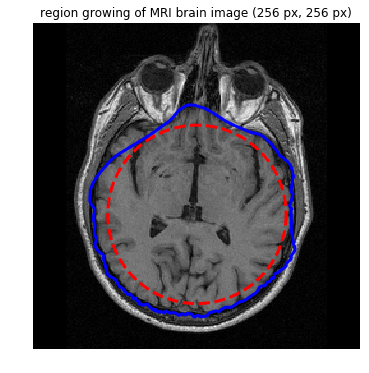

estimated area = 12732.395447351626


In [6]:
#Active contour with skimage
import skimage.segmentation as seg
#copy original image
active_contour = brain_im.copy()
#initialize snake as a circle
s = np.linspace(0, 2*np.pi, 400)
x = 128 + 70*np.cos(s)
y = 150 + 70*np.sin(s)
snake_init = np.array([x, y]).T
#apply active contour on active_contour image with snake_init as initial contour
#alpha: resistance to stretching. Here put to 0 because we expect the snake to stretch since snake_init is inside the brain
#beta: rigidity: resistance to bending. High value to capture the smooth round shape of the brain
#w_line controls attraction to brightness. Negative to attract to dark region (region between brain and skull)
#w_edge: controls attraction to edges
snake = seg.active_contour(active_contour, snake_init,alpha=0, beta=100, w_line=-2, w_edge=1.5, bc='periodic', max_px_move=2.0, max_iterations=5000)

#plot result
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(active_contour, cmap='gray')
ax.plot(snake_init[:, 0], snake_init[:,1],'--r', lw=3)
ax.plot(snake[:, 0], snake[:,1],'-b', lw=3)
ax.set_title('region growing of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

#approximate area by area of a circle with the same perimeter
r = snake.shape[0]/(2*np.pi)
area = np.pi*r*r
print('estimated area = {}'.format(area))

### 1.4 Additional method(s)
Add your implementation and discussion

### 1.5 Histogram thresholding
In this part a simple thresholding is implemented based on histogram results. It doesn't work so well as some parts of the skull has the same intensity as the brain. To try to improve results and exclude the skull pixels, a morphological opening with a smoothed square is used. After this operation, the resulting area is closer to previous results.

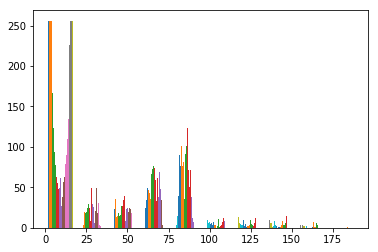

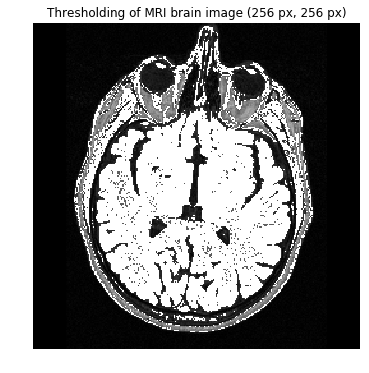

Calculated area: 19612


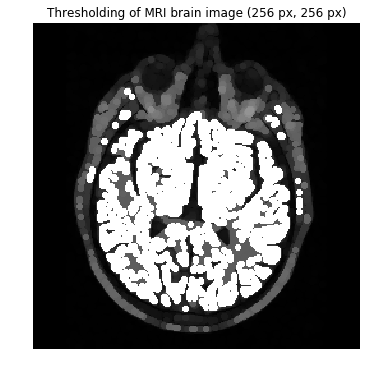

Calculated area: 14384


In [7]:
import skimage.exposure as expo
import skimage.morphology as morph
threshold = brain_im.copy()
plt.hist(threshold) #histogram to see where to put threshold. Brain should be between 55 and 90.
area = 0
for k in range(0, im_h):#saturates pixel if detected as brain by the threshold
    for l in range(0,im_w):
        if threshold[k][l] >= 55 and threshold[k][l] <= 90:
            threshold[k][l] = 255
            area = area+1

#plot result
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(threshold, cmap='gray')
ax.set_title('Thresholding of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()
print('Calculated area: {}'.format(area))

#try excluding outliers and improve results with morphology
area = 0
struct_elem = np.array([[0,1,1,1,0], [1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1], [0,1,1,1,0]])
out = morph.opening(threshold,struct_elem)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(out, cmap='gray')
ax.set_title('Thresholding of MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

for k in range(0, im_h):#go through image and compute number of saturated pixels
    for l in range(0,im_w):
        if out[k][l] == 255:
            area = area+1

print('Calculated area: {}'.format(area))

### 1.6 Morphological Watersheds
Discussion blabla

In [8]:
def region_merging(im,blk_size,seed_x,seed_y):
    B = view_as_blocks(im,block_shape=(blk_size,blk_size))
    blk_x,blk_y = (seed_x//blk_size,seed_y//blk_size)
    # TODO the rest


## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [9]:
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


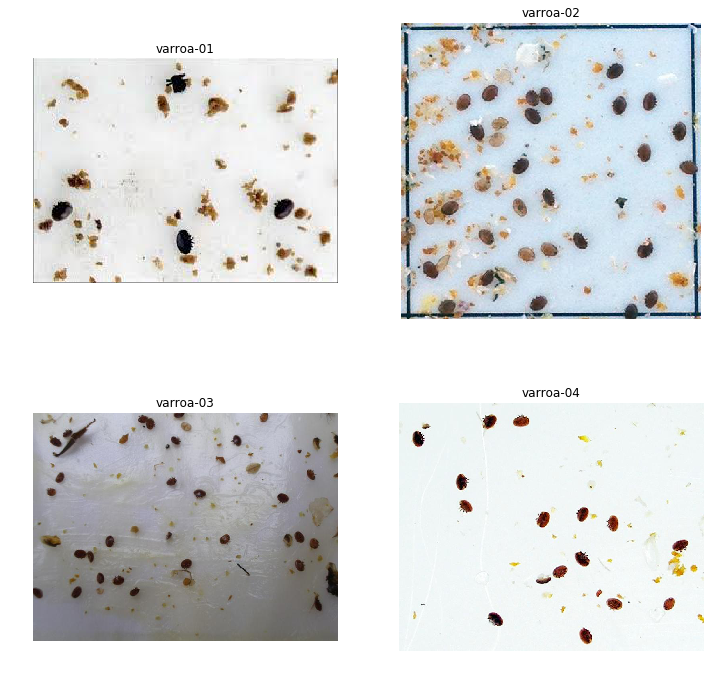

In [10]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [11]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [12]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

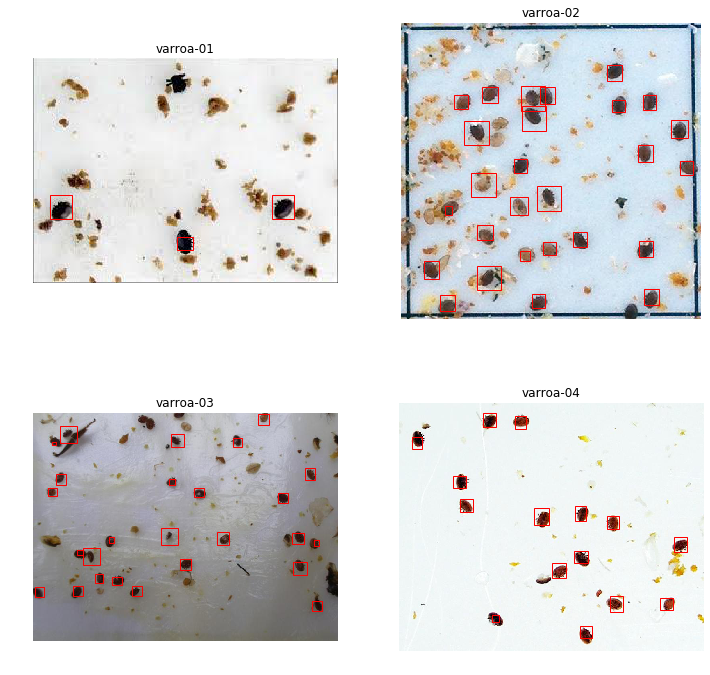

In [13]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture
Hint: `skimage.measure.label` might be useful to label the thresholded image

1) About the given images.

The four images gives us 4 differents situation to take in account.
1st image : Good contrast,homogenous lighting and varroas of same colours.
2st image : Good contrast but varroas of different colours + Having black border to handle
3rd image : Non-homogenous lightning which gives us a bad contrast.
4th image : Good contrast but varroas of different colours

2) About the processing and the counting method.

We went trough multiples phases in order to get an satisfying processing of the image.

1. We evaluated the performance of different thresholding methods on gray-scale image.
2. We evaluated if using only one color channel was giving us any benefits,which turned out to give worse results.
3. We evaluated constrast enhancement strategies on Gray-scale and RGB :

  * Constrast enhancement with YCbCr : RGB only 
  * Contrast Limited Adaptive Histogram Equalization : Both
  * Gamma enhancement  : Gray-scale
  * Sigmoidal Contrast enhancement : Gray-scale

  
4. Wrote the complete pipeline with the retained methods

On each of the subpoint we will discuss the reason of our selection

#### 2.2.1 Evaluation of automatic threshold methods on gray-scale images.
As we will see the most interesting method is the Minimum threshold. This method will take the histogram of the input image smoothed it until there are only two maxima, then the minimum in between is the threshold value. In our case the two maxima are the varroas and the white background.

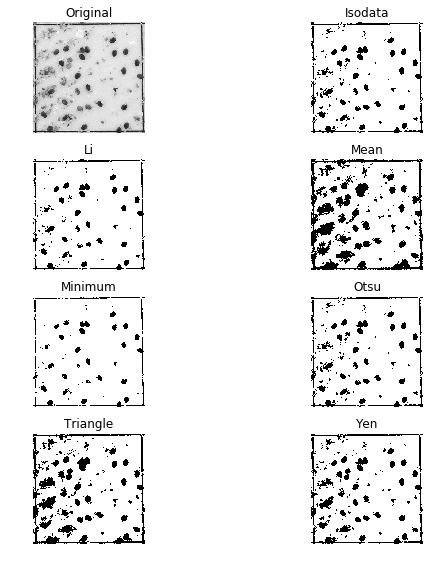

In [15]:
# ic is an image collection of the 4 images

# Try all kind of thresholding on gray_level images
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold
from skimage.color import rgb2gray

img_color = ic[1]
img_gray = rgb2gray(img_color)

fig, ax = try_all_threshold(img_gray, figsize=(10, 8), verbose=False)
plt.show()

#### 2.2.2 Evaluation of constrast enhancement methods.
As we will see all the methods improve the contrast in some way (except for the YCBCR method) but some makes also the varroas brighter which make them less identifiable. The sigmoid method makes the varroas darker therefore more identifiable (when it will be thresholded)

C:\Users\Ismail-P51\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


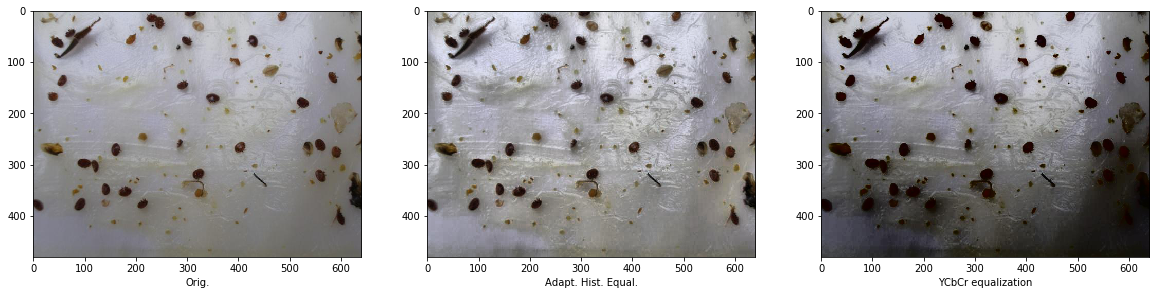

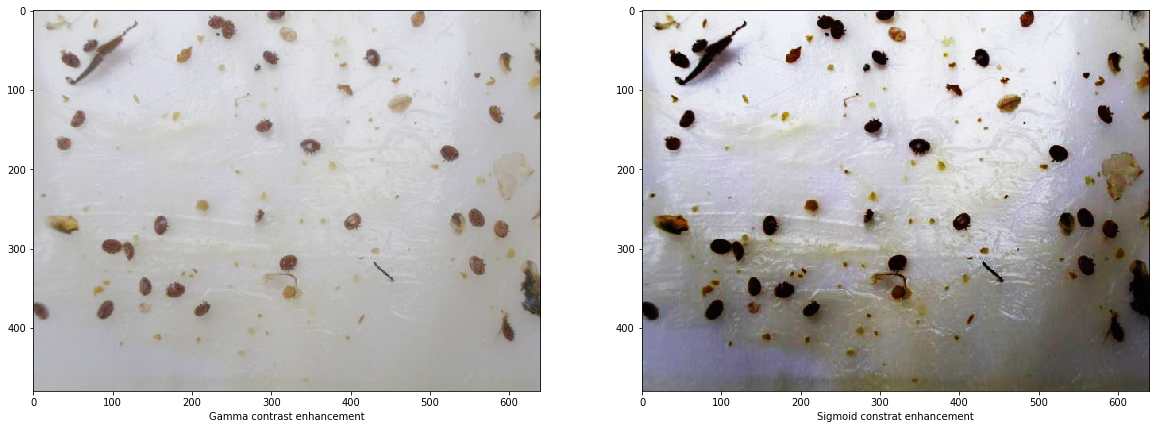

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from skimage.exposure import histogram
from skimage.color import rgb2gray

def eq_hist_rgb(image):
    """ Trying to equalize an RGB
        Reference : https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/ """
    im_ycbcr = skimage.color.rgb2ycbcr(image)
    y_range = (im_ycbcr[:,:,0].min(),im_ycbcr[:,:,0].max())
    y_eq = skimage.exposure.equalize_hist(im_ycbcr[...,0], nbins=256, mask=None)
    y_eq = skimage.exposure.rescale_intensity(y_eq,out_range=y_range)   
    im_ycbcr[:,:,0] = y_eq
    im_rgb = skimage.color.ycbcr2rgb(im_ycbcr)
    return im_rgb

# Adjust contrast of images with histogram equalization
gamma_p = 0.5
sigmoid_p = 0.5
img_color = ic[2]
img_adapt = skimage.exposure.equalize_adapthist(img_color, kernel_size=None, clip_limit=0.01, nbins=256)
#img_eqhist = eq_hist_rgb(img_color)
img_gamma = skimage.exposure.adjust_gamma(img_color, gamma=gamma_p, gain=1)
img_sigma = skimage.exposure.adjust_sigmoid(img_color, cutoff=sigmoid_p, gain=10, inv=False)

fig,ax = plt.subplots(ncols=3,figsize=(20,20))
ax[0].imshow(img_color)
ax[0].set_xlabel('Orig.')
ax[1].imshow(img_adapt)
ax[1].set_xlabel('Adapt. Hist. Equal.')
ax[2].imshow(img_eqhist)
ax[2].set_xlabel('YCbCr equalization')
fig,ax = plt.subplots(ncols=2,figsize=(20,20))
ax[0].imshow(img_gamma)
ax[0].set_xlabel('Gamma contrast enhancement')
ax[1].imshow(img_sigma)
ax[1].set_xlabel('Sigmoid constrat enhancement')

plt.show()

#### 2.2.3 Processing pipeline and labelling
The processing pipeline is the following :
1. Enhancement of the constrast with sigmoid enhancement.
2. Dilation and erosion in order to keep only the varroas (and remove honey and black lines on the background)
3. Thresholding with the minimum threshold method and binarization

The labeling is using the binarized image to label each region

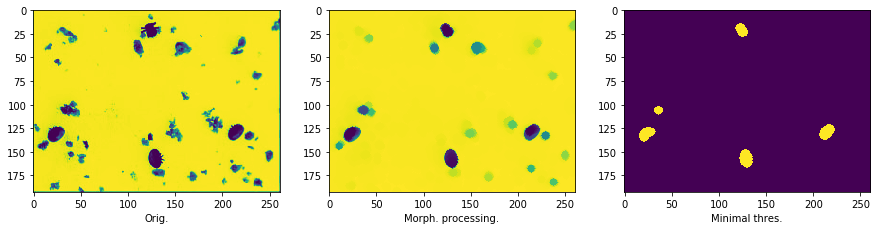

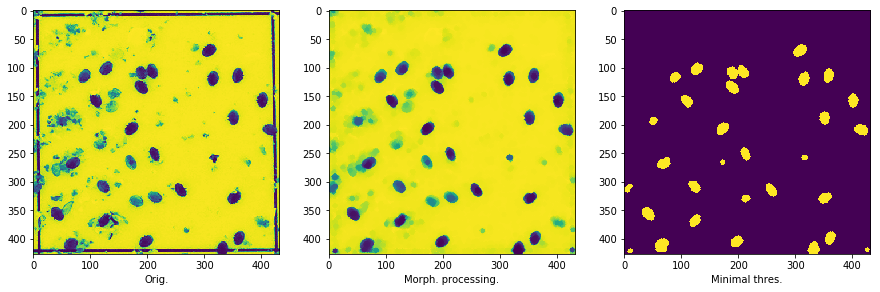

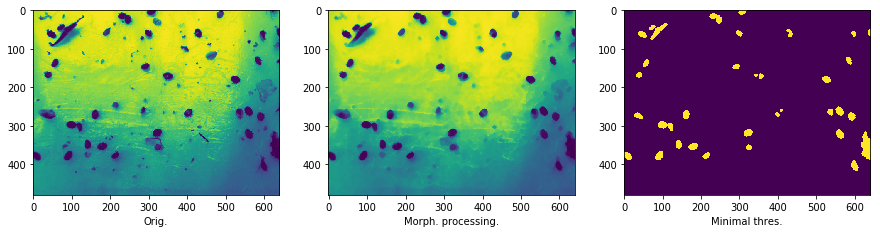

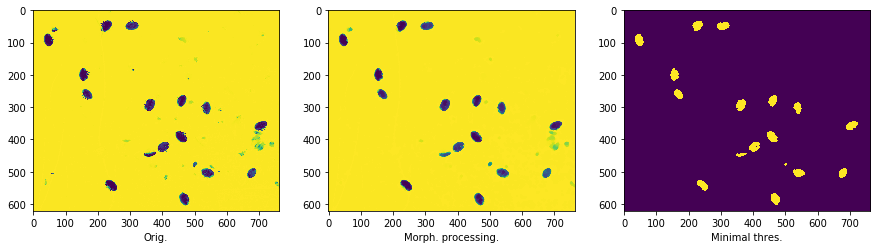

In [29]:
# Import stuff
from skimage.filters import threshold_minimum
from skimage.color   import rgb2gray
from skimage.measure import label

from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

def pipeline(rgb_input_img):
    """ Input : RGB image of varroa infection
        Ouput : Binary image of detected varroa 
        Function : Process the image in order to keep the relevant informations """
    # Data : ic[0..3]
    color = {'red':0,'green':1,'blue':2}

    # Principal pipeline 

    # Preprocessing
    
    # Contrast enhancement
    sigmoid_p = 0.5
    #rgb_input_img = skimage.exposure.equalize_adapthist(rgb_input_img, kernel_size=None, clip_limit=0.01, nbins=256)
    rgb_input_img = skimage.exposure.adjust_sigmoid(rgb_input_img, cutoff=sigmoid_p, gain=10, inv=False)    
    
    # Color Selection
    single_canal = False
    
    if single_canal==True:
        input_img = rgb_input_img[:,:,color['red']]  # Take a single canal 
    else:
        input_img = rgb2gray(rgb_input_img)
    
    # Morphology operations
    
    struct_elem = disk(4)
    morph_img   = dilation(input_img, struct_elem)# Remove waste on images
    struct_elem = disk(4)
    morph_img   = erosion(morph_img,struct_elem) # Give proportion again to varroa
    
    # Thresholding
    
    # Minimum method thres.
    min_thres = threshold_minimum(morph_img)
        
    # Binarization
    bin_min  = morph_img < min_thres


    # Plot the results
    plot_processing = True
    if True == plot_processing:
        fig, axes = plt.subplots(ncols=3, figsize=(15, 15))
        ax = axes.ravel()

        ax[0].imshow(input_img)
        ax[0].set_xlabel('Orig.')

        ax[1].imshow(morph_img)
        ax[1].set_xlabel('Morph. processing.')

        ax[2].imshow(bin_min)
        ax[2].set_xlabel('Minimal thres.')
        plt.show()
    
    
    # Assign the output to final processing
    output = bin_min
    
    return output

def label_varroa_region(input_image):
    """ Input  : Binary image of detected varroa
        Output : Multiples labellised regions of the image"""
    output_labels,num_labels = label(input_image,return_num=True,connectivity=None)
    return output_labels

label_list = []

for img in ic:
    bin_img = pipeline(img)
    output_labels = label_varroa_region(bin_img)
    label_list.append(output_labels)



### 2.3 IoU of the detected pattern w.r.t. the ground truth

To be able to compute the IoU will use the bounding boxes given by both the XML annotations for the ground truth and by the skimage imageprops for the predicted part.

We also wrote a function that will allow us to compute the later asked statistics

To this purpose we implemented the following functions. 
* A conversion function __xml_annotation_to_bbox__ to have similar data types between the xml bbox and the regionprops bbox
* A IoU computation __iou_bbox__ per pair of bboxes (ground truth and predicted one)
* A general function __detection_statistics__ that will return statistics about the bboxes s.t 
  * True and false positive about predicted region
  * False negative about the ground truth region

In [33]:
from skimage.measure import regionprops

def xml_annotation_to_bbox(xml_annotation):
    """ Convert an xml annotation to a list of bbox tuples"""
    bbox_list = []
    for elem in xml_annotation:
        bbox_coords = elem['bbox']
        bbox_tuple  = tuple(bbox_coords)
        bbox_list.append(bbox_tuple)
    
    return bbox_list


def iou_bbox(gt_reg,pred_reg):
    """ 
        Compute the IoU between two region with their bounding boxes
        
        Insipired from : https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
        
        Parameters
        ----- 
        pred_reg format : (MIN_ROW,MIN_COL,MAX_ROW,MAX_COL)
        pred_reg pixels in bounding box are in half-open interval [min_row; max_row) and [min_col; max_col).
        gt_reg h-format : (x, y, width, heigth) in some cartesian form
        gt_reg format   : (MIN_COL,MIN_ROW, MAX_ROW-MIN_ROW, MAX_COL-MIN_COL)
        
        Return
        -----
        float val in [0,1]
    """
    # x:rows and y:colummns are (0,0) at right corner
    
    # Harmonize the coordinates systems of the bounding boxes
    g_y_min,g_x_min,diff_x,diff_y   = gt_reg
    g_y_max = g_y_min + diff_y 
    g_x_max = g_x_min + diff_x
    
    # In ground truth max_values are inside the bbox but in label are outside 
    p_x_min,p_y_min,p_x_max,p_y_max = pred_reg
    # Correction of max values
    p_x_max = p_x_max - 1
    p_y_max = p_y_max - 1
    
    # Determine the (x,y) coordinates of the intersection rectangle
    i_x_min = max(p_x_min,g_x_min)
    i_y_min = max(p_y_min,g_y_min)
    i_x_max = min(p_x_max,g_x_max)
    i_y_max = min(p_y_max,g_y_max)
    
    # Compute the intersection area (robust to non-matching rect.s)
    inter_area = max(0,i_x_max -  i_x_min + 1) * max(0,i_y_max - i_y_min + 1)
    
    
    # Compute the area of both the prediction and the ground-truth
    pred_rect = (p_x_max-p_x_min+1)*(p_y_max-p_y_min+1) 
    gt_rect   = (g_x_max-g_x_min+1)*(g_y_max-g_y_min+1)

    debug_print = False
    
    if True == debug_print:
        print(" GT : {}:{}/{}:{}".format(g_x_min,g_y_min,g_x_max,g_y_max))
        print(" PR : {}:{}/{}:{}".format(p_x_min,p_y_min,p_x_max,p_y_max))
        print("INTER : {}".format(inter_area))
        print("PRED_AREA : {}".format(pred_rect))
        print("GT   AREA : {}".format(gt_rect))
    
    # Compute the intersection over union
    iou_val = inter_area/(gt_rect+pred_rect-inter_area)
    return iou_val
    
    

def detection_statistics(pred_image,gt_labels,threshold):
    """
    
    Returns a tuple composed by pred_region_stats and gt_region_stats
    
    Parameters
    ------
    pred_image : labeled image
    gt_labels  : list of bbox tuples per ground truth region
    threshold  : IoU threshold
    
    Returns
    ------
    (pred_region_stats,gt_region_stats)
    
    pred_region_stats :
    a list of size of number of predicted region having the following status depending on the IoU criteria
    3 : True  positive (region is correct)
    1 : False positive (region doesn't exist in ground truth or don't match enough)
    
    gt_region_stats :
    a list of size of number of ground truth region having the following status depending on the IoU criteria
    0 : Region being detected
    -3: False negative (existing region not detected)
    """
    debug_print = False # Variable to enable debuging information  
        
    props_list = regionprops(pred_image) # Properties of the labelled image
    pred_region_status = np.zeros(len(props_list)) # Select between true or false positive
    pred_region_argmax = np.zeros(len(props_list)) # Array that stores the best IoU idx per predicted region
    gt_region_status = np.zeros(len(gt_labels))    # Store if ground truth region is being detected.
    
    # Rows : Gt regions,Cols : Predicted regions
    iou_array = np.zeros((len(gt_labels),len(props_list)),dtype=np.float64)     
    
    # Compute all the IoU bruteforce method
    for idx_a,a in enumerate(gt_labels):
        for idx_b,b in enumerate(props_list):
            b_bbox = b.bbox
            
            # Debug info begin
            if True == debug_print:
                print("gt_idx {} / reg_idx {} ".format(idx_a,idx_b))
                print("Bbox coords ----------")
                print("GT : {}\nPRED : {}".format(a,b_bbox))
            # Debug info end
            iou_array[idx_a,idx_b] = iou_bbox(a,b_bbox)
    
    # Debug info begin
    if True == debug_print:
        print("--------------")
        print("mtx size : {}",iou_array.shape)
        print(iou_array)
        print("--------------")
    # Debug info end
    
    # Compute the false positive (pred region which IoU equals 0 over the ground truth is equal to zero)
    false_pos_idx = [iou_array.sum(0) == 0]
    pred_region_status[false_pos_idx] = 1.0 # False positive
    pred_region_argmax[false_pos_idx] = -1.0 # False positive then no assignation to a region
    
    # Compute the true positive depending on the threshold
    for pred_idx,elem in enumerate(pred_region_status):
        if elem != 1.0:
            gt_idx = iou_array[:,pred_idx].argmax() # Get the maximum IoU
            # Check if IoU is above the threshold
            if iou_array[gt_idx,pred_idx] >= threshold:
                pred_region_status[pred_idx] = 3. # True positive
                pred_region_argmax[pred_idx] = gt_idx # Assign the predicted region to a ground truth region
            else:
                pred_region_status[pred_idx] = 1.   # False positive
                pred_region_argmax[pred_idx] = -1.0 # False positive then no assignation to a region       
                
    # Compute the false negative
    for idx,elem in enumerate(gt_region_status):
        if idx not in pred_region_argmax: # If no predicted region has been assigned to a ground truth region
            gt_region_status[idx] = -3.0 # False negative
    
    return (pred_region_status,gt_region_status)
    


### 2.4 Precision, Recall and F1-score at two different IoU thresholds
The implementation is quite straightforward

In [31]:
def precision(region_stats,gt_stats):
    """ Compute the precision of the image detection tp/tp+fp"""
    unique,counts = np.unique(region_stats, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    tp = stats_dict.get(3.0,0.0) # Get the number of true positive
    fp = stats_dict.get(1.0,0.0) # Get the number of false positive 
    
    # If nothing is detected then return zero (avoid numerical error)
    if 0.0 == tp+fp:
        return 0.0
    else:
        return tp/(tp+fp)

def recall(region_stats,gt_stats):
    """ Compute the recall of the image detection tp/tp+fn"""
    
    unique,counts = np.unique(region_stats, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    tp = stats_dict.get(3.0,0.0) # Get the number of true positive
    
    unique,counts = np.unique(gt_stats, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    fn = stats_dict.get(-3.0,0.0) # Get the number of false negative 
    
    # If nothing is detected then return zero (avoid numerical error)
    if 0.0 == tp+fn :
        return 0.0
    else:
        return tp/(tp+fn)
    
    

def f1_score(region_stats,gt_stats):
    """"""
    rec  = recall(region_stats,gt_stats)
    prec = precision(region_stats,gt_stats)
    
    # If nothing is detected then return zero (avoid numerical error)
    if 0. == prec or 0. == rec:
        f1_val = 0.0
    else:
        f1_val = 2*prec*rec/(rec+prec)
    print("Stats : Rec : {} / Prec : {} / F1-score : {}".format(rec,prec,f1_val))
    return f1_val

### 2.5 Demonstration of the IoU thresholds with statistics

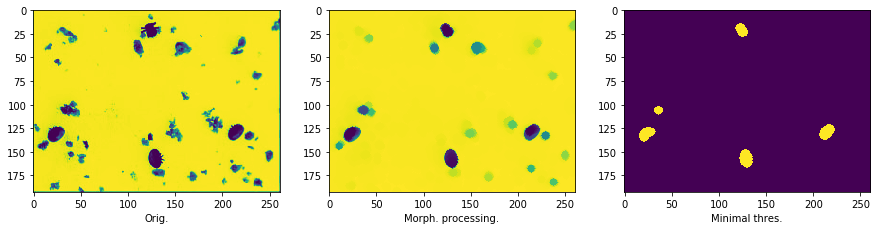

Image N° 0
IoU threshold : 0.4
Stats : Rec : 1.0 / Prec : 0.6 / F1-score : 0.7499999999999999
IoU threshold : 0.5
Stats : Rec : 0.6666666666666666 / Prec : 0.4 / F1-score : 0.5
IoU threshold : 0.9
Stats : Rec : 0.0 / Prec : 0.0 / F1-score : 0.0


C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:130: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


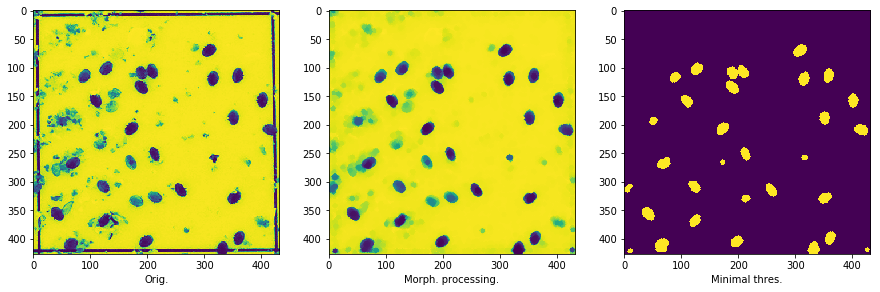

Image N° 1
IoU threshold : 0.4
Stats : Rec : 0.7037037037037037 / Prec : 0.6333333333333333 / F1-score : 0.6666666666666667
IoU threshold : 0.5
Stats : Rec : 0.5185185185185185 / Prec : 0.4666666666666667 / F1-score : 0.4912280701754386
IoU threshold : 0.9
Stats : Rec : 0.037037037037037035 / Prec : 0.03333333333333333 / F1-score : 0.03508771929824562


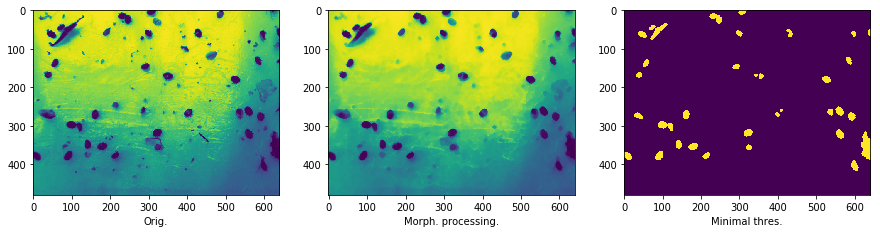

Image N° 2
IoU threshold : 0.4
Stats : Rec : 0.5769230769230769 / Prec : 0.4411764705882353 / F1-score : 0.5
IoU threshold : 0.5
Stats : Rec : 0.4230769230769231 / Prec : 0.3235294117647059 / F1-score : 0.3666666666666667
IoU threshold : 0.9
Stats : Rec : 0.0 / Prec : 0.0 / F1-score : 0.0


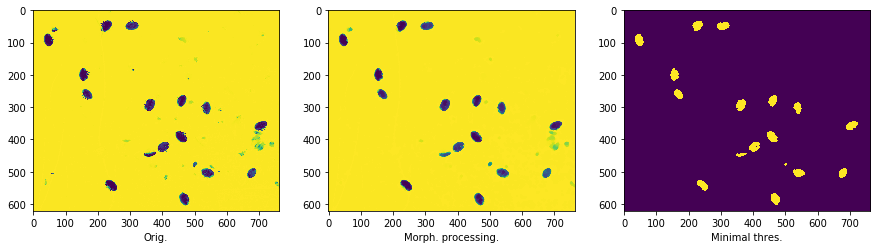

Image N° 3
IoU threshold : 0.4
Stats : Rec : 0.9333333333333333 / Prec : 0.8235294117647058 / F1-score : 0.8749999999999999
IoU threshold : 0.5
Stats : Rec : 0.8 / Prec : 0.7058823529411765 / F1-score : 0.7500000000000001
IoU threshold : 0.9
Stats : Rec : 0.0 / Prec : 0.0 / F1-score : 0.0


In [32]:
# Process the images and print some statistics
# TODO : No print at the moment 
for idx,img in enumerate(ic):
    bin_img = pipeline(img)
    label_img = label_varroa_region(bin_img)
    gt_labels = xml_annotation_to_bbox(annotations_xmls[idx])
    # Proceed to gather statistics
    print("Image N° {}".format(idx))
    thres_list =  [0.4,0.5,0.9]
    for thres in thres_list:
        print("IoU threshold : {}".format(thres))
        reg_stats,gt_stats = detection_statistics(label_img,gt_labels,thres)
        # print("Region Stats : {}".format(reg_stats))
        # print("Gt Stats : {}".format(gt_stats))
        f1_score(reg_stats,gt_stats)
        